In [16]:
from random import shuffle

import os
import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from tqdm import tqdm, tqdm_notebook

from data_utils import ImageClipDataset, split_clips_dataset

In [18]:
BATCH_SIZE = 16
NUM_THREADS = 4

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomAffine(15, (0.2, 0.2)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                      std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                      std=[0.229, 0.224, 0.225]),
    ])
}

In [12]:
%prun clips = ImageClipDataset('./data/images/', transform=data_transforms['train'])

         2205860 function calls in 1.263 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   301695    0.292    0.000    0.424    0.000 ntpath.py:122(splitdrive)
        1    0.251    0.251    1.258    1.258 data_utils.py:72(_make_dataset)
     6637    0.220    0.000    0.220    0.000 {built-in method nt.scandir}
    61897    0.181    0.000    0.623    0.000 ntpath.py:75(join)
    55250    0.054    0.000    0.133    0.000 folder.py:9(has_file_allowed_extension)
   301696    0.050    0.000    0.050    0.000 {method 'replace' of 'str' objects}
   363594    0.046    0.000    0.046    0.000 {built-in method builtins.isinstance}
   165750    0.035    0.000    0.056    0.000 folder.py:19(<genexpr>)
   363594    0.031    0.000    0.031    0.000 {built-in method nt.fspath}
     1100    0.022    0.000    0.023    0.000 data_utils.py:83(<listcomp>)
   301713    0.022    0.000    0.022    0.000 {built-in method builtins.len}
   110500 

In [20]:
print(clips)

Dataset ImageClipDataset
    Number of classes: 11
    Number of videos: 1100
    Number of datapoints: 55250
    Root Location: D:\Studies\FEEC\sumarizacao\data\images
    Transforms (if any): Compose(
                             Resize(size=256, interpolation=PIL.Image.BILINEAR)
                             RandomAffine(degrees=(-15, 15), translate=(0.2, 0.2))
                             CenterCrop(size=(224, 224))
                             ToTensor()
                         )
    Target Transforms (if any): None


In [21]:
clips[np.random.randint(0, len(clips))]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.1373, 0.1373, 0.1373],
          [0.0000, 0.0000, 0.0000,  ..., 0.1373, 0.1373, 0.1373],
          [0.0000, 0.0000, 0.0000,  ..., 0.1373, 0.1373, 0.1373],
          ...,
          [0.1333, 0.1333, 0.1333,  ..., 0.1529, 0.1529, 0.1490],
          [0.1333, 0.1333, 0.1333,  ..., 0.1490, 0.1490, 0.1490],
          [0.1333, 0.1333, 0.1333,  ..., 0.1490, 0.1490, 0.1490]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.1176, 0.1176, 0.1176],
          [0.0000, 0.0000, 0.0000,  ..., 0.1176, 0.1176, 0.1176],
          [0.0000, 0.0000, 0.0000,  ..., 0.1176, 0.1176, 0.1176],
          ...,
          [0.1176, 0.1176, 0.1176,  ..., 0.1255, 0.1255, 0.1294],
          [0.1176, 0.1176, 0.1176,  ..., 0.1294, 0.1294, 0.1294],
          [0.1137, 0.1176, 0.1176,  ..., 0.1294, 0.1294, 0.1294]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.6118, 0.6118, 0.6118],
          [0.0000, 0.0000, 0.0000,  ..., 0.6118, 0.6118, 0.6118],
          [0.0000, 0.0000, 0.0000,  ...,

In [14]:
train_set, validation_set = split_clips_dataset(clips, 0.2)

In [19]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers=NUM_THREADS)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE,
                                                shuffle=False, num_workers=NUM_THREADS)

In [8]:
class VideoFrameClassifier(nn.Module):
    def __init__(self, pretrained_model):
        super(VideoFrameClassifier, self).__init__()
        
        self.base = nn.Sequential(*list(pretrained_model.children())[:-1])
        self.classifier = nn.Linear(in_features=2048, out_features=13, bias=True)
        
    def forward(self, images):
        batch_size = images.shape[0]
        X = F.relu(self.base(images))
        X = X.view(batch_size, -1)
        X = F.softmax(self.classifier(X), dim=-1)
        return X

In [9]:
video_classifier = VideoFrameClassifier(base_resnet50)
video_classifier = video_classifier.to(device)

In [10]:
optimizer = torch.optim.Adam(video_classifier.parameters(), lr=1e-6)
criterion = nn.CrossEntropyLoss()

In [11]:
loss_history = []
hit_history = []
num_epochs = 50
for epoch in tqdm(range(0, num_epochs)):
    hits = 0
    for (images, targets) in train_loader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        predictions = video_classifier(images)
        loss = criterion(predictions, targets)
        loss.backward()
        hits += (predictions.max(dim=1)[1] == targets).sum()
        optimizer.step()
    loss_history.append(loss)
    hit_history.append(hits)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [28:21:03<00:00, 2332.87s/it]


In [12]:
(predictions.max(dim=1)[1] == targets).sum()

tensor(7, device='cuda:0')

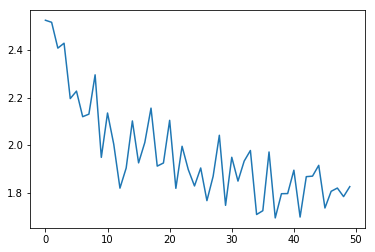

In [13]:
plt.plot(loss_history)

In [14]:
hits

tensor(10545, device='cuda:0')

In [23]:
acc = torch.Tensor(hit_history) / len(train_dataset.dataset.samples)

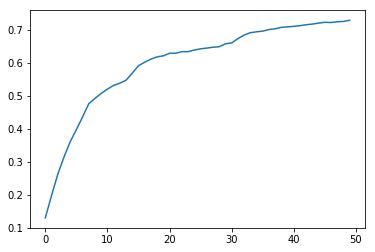

In [24]:
plt.plot(acc.tolist())

In [35]:
len(train_dataset.dataset.samples)

14450

## TODO
1. Regularizar (L! pra esparsificar)
2. Mais videos e mais frames por video
3. Classificação por video (maioria no vídeo)
4. Estado de atenção